# ECE6530 DSP Group 3 Project
## Lab P-9: Sampling, Convolution, and FIR Filtering

### Group Members: Rick Lyon, Grant Brown, Thomas Warren

In [1]:
# Load the required libraries
import matplotlib.pyplot as plt
import numpy as np
from lab9_defs import stem_plot, filter_2d
from scipy.io import loadmat, wavfile
from pathlib import Path
from IPython import display

%config InlineBackend.figure_formats = ['svg']

Setup
---------

To generate this report and the associated plots:

1. Install Python 3.11.
2. Open a terminal window and navigate to the directory containing the project files. 
2. Create an virtual environment for the report/project. See [here](https://docs.python.org/3/library/venv.html) for more information.  
`> python -m venv .venv`
4. In the newly created environment, install the required packages from the requirements.txt file included with the project files.  
`(.venv) > pip install -r requirements.txt`
5. Open the report with Jupyter Notebooks.  
`(.venv) > jupyter notebook lab9.ipynb`
6. The notebook should open in the default browser. 

7. To generate the .html version of the report,  
`(.venv) > jupyter nbconvert --to html lab9.ipynb`

# 3.1 - Deconvolution Experiment for 1-D Filters
----

Implement the following FIR filter
$$ w[n] = x[n] - 0.9x[n-1]$$
on the input signal x[n] defined via the MATLAB statement: 
```
xx = 256*(rem(0:100,50)<10);
```
In MATLAB you must define the vector of filter coefficients bb needed in `firfilt`.

## (a) 

Plot both the input and output waveforms x[n] and w[n] on the same figure, using subplot. Make the discrete-time signal plots with MATLAB’s stem function, but restrict the horizontal axis to the range $0 \leq n \leq 75$.  
Explain why the output appears the way it does by figuring out (mathematically) the effect of the filter coefficients in (3).

The output is the difference of the current sample n and the previous sample at n-1 with an scalar of 0.9 applied to the previous sample. The scalar causes the difference to be nonzero and 0.1 times the previous value. The edges of x[n] are visible due to the difference equation causing the value to be 0.9 times the previous value. The effect of the filter coefficients is essentially an edge detection or derivative filter.

Text(0.5, 0, 'Samples')

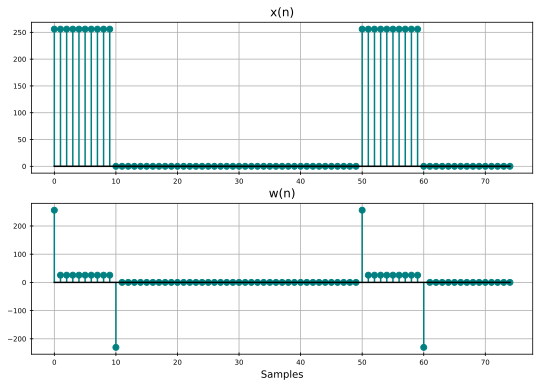

In [2]:
# create xn signal
n = np.arange(0, 101)
x_n = 256 * ((n % 50) < 10)

# apply difference FIR filter to create wn
w_n = np.convolve([1, -0.9], x_n)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
stem_plot(ax1, n[0:75], x_n[0:75])
stem_plot(ax2, n[0:75], w_n[0:75])

ax1.set_title("x(n)")
ax2.set_title("w(n)")
ax2.set_xlabel("Samples")

## (b) 

Note that w[n] and x[n] are not the same length. Determine the length of the filtered signal w[n], and explain how its length is related to the length of x[n] and the length of the FIR filter. (If you need a hint refer to Section 1.2.)

The FIR filter in this example has coefficients $bb = [1 0.9]$, so it is length 2. The output of the convolution can be determined by the length of the two sequences given as inputs to the convolution operation, which in this case would be:
$$
\mathrm{len}(w[n]) = \mathrm{len}(x[n]) + \mathrm{len}(bb) -1 = 101 + 2 - 1 = 102
$$

# 3.1.1 Restoration Filter
------

The following FIR filter:
$$ y[n] = \sum_{l=0}^{M} r^l w[n-l] $$
can be use to undo the effects of the FIR filter in the previous section. It performs restoration, but it only does this approximately. Use the following steps to show how well it works when r = 0.9 and M = 22.

## (a) 

Process the signal $w[n]$ from (3) with FILTER-2 to obtain the output signal $y[n]$.

## (b) 

Make stem plots of $w[n]$ and $y[n]$ using a time-index axis n that is the same for both signals. Put the stem plots in the same window for comparison—using a two-panel subplot.

Text(0.5, 0, 'Samples [n]')

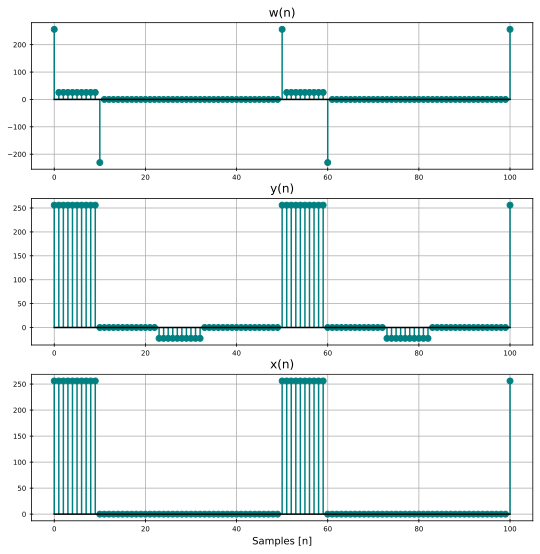

In [3]:
# build restoration filter cooeficients
M = 22
l = np.arange(0, M + 1, dtype=np.int8)
r = 0.9**l
y_n = np.convolve(r, w_n)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))
stem_plot(ax1, n, w_n[:-1])
stem_plot(ax2, n, y_n[:-M -1])
stem_plot(ax3, n, x_n)

ax1.set_title("w(n)")
ax2.set_title("y(n)")
ax3.set_title("x(n)")
ax3.set_xlabel("Samples [n]")

# (c) 

Since the objective of the restoration filter is to produce a y[n] that is almost identical to x[n], make a plot of the error (difference) between x[n] and y[n] over the range $0 < n < 50$.

Text(0.5, 16.878125000000008, 'Samples [n]')

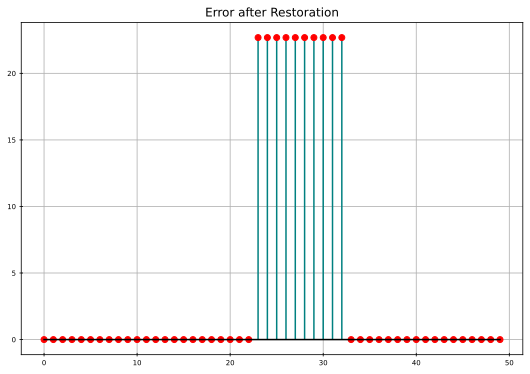

In [4]:
error = np.abs(y_n[:50] - x_n[:50])

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.stem(error, markerfmt="red")
ax.title.set_text("Error after Restoration")
ax3.set_xlabel("Samples [n]")

# 3.1.2 - Worst-Case Error
----
# (a) 
Evaluate the worst-case error by doing the following: use MATLAB’s max() function to find the maximum of the difference between y[n] and x[n] in the range $0 < n < 50$.

# (b) 
What does the error plot and worst case error tell you about the quality of the restoration of x[n]? How small do you think the worst case error has to be so that it cannot be seen on a plot?

In [5]:
max_error = np.max(error[0:50])
print(f"Maximum Error found is {max_error:.3f}")

Maximum Error found is 22.689


The error plot will show how effective the deconvolution/restoration operation is. The maximum error can be used as a threshold for a certain application to allow us to determine how high an order of a deconvolution filter we need. Increasing M, the filter order, has shown to create a better deconvolution operation. In order to no longer see the error in our plots, the value of error would need to be smaller than 0.1. Anything smaller than 0.1 would be hard to detect with the markers for the stem plot. 

# 3.1.3 - An Echo Filter
-------

The following FIR filter can be interpreted as an echo filter.
$$y_1[n] = x_1[n] + rx_1[n-P]$$

Explain why this is a valid interpretation by working out the following:

# (a) 
You have an audio signal sampled at $f_s = 8000 Hz$ and you would like to add a delayed version of the signal to simulate an echo. The time delay of the echo should be 0.2 seconds, and the strength of the echo should be 90% percent of the original. Determine the values of r and P in (4); make P an integer.

To solve this we must known how many samples we are offsetting by with the 0.2 seconds of delay. Since we are sampling at 8000 Hz which is 8000 samples/sec, then we are offsetting by: $8000 samples/sec * 0.2 sec = 1600 samples$. Therefore, P should be 1600. Since the signal should be at 90% of its value then r should be 0.9. Giving the echo filter equation:

$$y_1[n] = x_1[n] + 0.9 \ x_1[n-1600]$$

In [6]:
# playback original data before filtering
orig_data = loadmat("data/labdat.mat")["x2"].squeeze()
orig_wavfile = "outputs/test.wav"
fs = 8000 # sampling rate

wavfile.write(orig_wavfile, fs, orig_data)
display.Audio(orig_wavfile)

# (b) 

Describe the filter coefficients of this FIR filter, and determine its length.
A FIR filter is in the form:
$$y[n] = \sum_{k=0}^{M} = b_k x[n-k]$$

with $b_k$ being the coefficients of the filter. This means that k = 1600 here and therefore the coefficients range from k=0 to 1600. Therefore the length of the filter is 1601.
The coefficients are  
`bb = [1; zeros(1599); 0.9]`

In [7]:
td = 0.2 # time delay of echo in seconds
echo_amp = 0.9 # amplitude of echo

samp_delay = int(fs * td) # total number of samples to delay the echo by
# create filter cooeficients
bk = np.zeros(samp_delay, dtype=float)
bk[0] = 1
bk[samp_delay - 1] = echo_amp

# apply filter to input data to create echo
echo_data = np.convolve(orig_data, bk)
echo_data_scaled = np.int16(echo_data / np.max(np.abs(echo_data)) * 32767)

# create wavfile and playback
echo_wavfile = "outputs/Echo_data.wav"
wavfile.write(echo_wavfile, fs, echo_data_scaled)

display.Audio(echo_wavfile)

# 3.2 Cascading Two Systems
----

More complicated systems are often made up from simple building blocks. In the system of Fig. 3 two FIR filters are connected “in cascade.” 

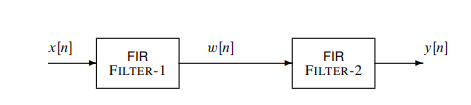

For this section, assume that the the filters in Fig. 3 are described by the two equations:

$$w[n] = x[n] - qx[n-1]$$
$$y[n] = \sum_{l=0}^{M} r^l w[n-l]$$



# 3.2.1 Overall Impulse Response
-------

# (a) 

Implement the system in Fig. 3 using MATLAB to get the impulse response of the overall cascaded system for the case where q = 0.9, r = 0.9 and M = 22. Use two calls to `firfilt()`. Plot the impulse response of the overall cascaded system.

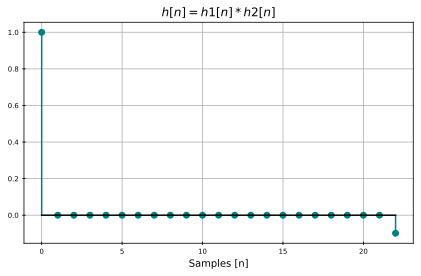

In [8]:
q = 0.9
r = 0.9
M = 22
h1_n = np.array([1, -q])

n = np.arange(M)
h2_n = r**n

hn = np.convolve(h2_n, h1_n)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
stem_plot(ax, np.arange(len(hn)), hn)
ax.set_title("$h[n] = h1[n] * h2[n]$")
ax.set_xlabel("Samples [n]");

# (b) 

Work out the impulse response h[n] of the cascaded system by hand to verify that your MATLAB result in part (a) is correct. (Hint: consult old Homework problems.)

To solve this we should note that convolution in time domain is multiplication in frequency domain,

$$W[z] = X[z](1-qz^{-1}) \longrightarrow H_1(z) = W[z] / X[z] = (1-qz^{-1})$$

$$Y[z] = W[z]R[z]$$ 

where,
$$Z^{-1}(R[z]) = r[n] = r^n(u[n] - u(n-22))$$

Taking the Z-transform of r[n] we get:

This is essentially a delta function with a negative scaled echo of the delta function

# (c) 

In a deconvolution application, the second system (FIR FILTER-2) tries to undo the convolution effect of the first. Perfect deconvolution would require that the cascade combination of the two systems be equivalent to the identity system: y[n] = x[n]. If the impulse responses of the two systems are $h_1[n]$ and $h_2[n]$, state the condition on $h_1[n]$ * $h_2[n]$ to achieve perfect deconvolution.

To implement perfect deconvolution we should note that convolution of x[n] with an impulse just gives x[n] at the output. Therefore $h_1[n]$ * $h_2[n]$ = $\delta [n]$

# 3.2.2 Distorting and Restoring Images
------

If we pick q to be a little less than 1.0, then the first system (FIR FILTER-1) will cause distortion when applied to the rows and columns of an image. The objective in this section is to show that we can use the second system (FIR FILTER-2) to undo this distortion (more or less). Since FIR FILTER-2 will try to undo the convolutional effect of the first, it acts as a deconvolution operator.

# (a) 

Load in the image echart.mat with the load command. It creates a matrix called echart.
# (b) 

Pick q = 0.9 in FILTER-1 and filter the image echart in both directions: apply FILTER-1 along the horizontal direction and then filter the resulting image along the vertical direction also with FILTER-1. Call the result ech90.
# (c) 

Deconvolve ech90 with FIR FILTER-2, choosing M = 22 and r = 0.9. Describe the visual appearance of the output, and explain its features by invoking your mathematical understanding of the cascade filtering process. Explain why you see “ghosts” in the output image, and use some previous calculations to determine how big the ghosts (or echoes) are, and where they are located. Evaluate the worst-case error in order to say how big the ghosts are relative to “black-white” transitions which are 0 to 255.

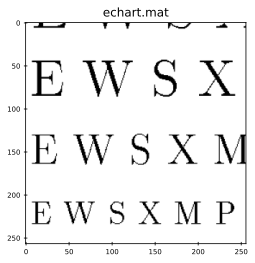

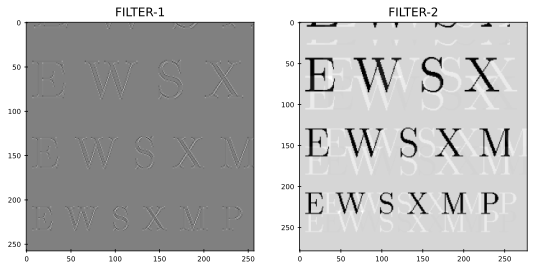

In [9]:
# create impulse response for FILTER-1
q = 0.9
r = 0.9
M = 22
h1_n = np.array([1, -q])

# create impulse response for FILTER-2
n = np.arange(M)
h2_n = r**n

# load image file
echart = loadmat("data/echart.mat")["echart"]

# normalize so image max is 1
echart = 1 - (echart / 255)

# apply FILTER-1 to image in both horizontal and vertical directions
ech90 = filter_2d(echart, h1_n)
# undo the effects of FILTER 1 by applying the deconvolutional filter to the result
ech90_decv = filter_2d(ech90, h2_n)

fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
ax1.imshow(echart, cmap="binary")
ax1.set_title("echart.mat")
ax1.grid(False)

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(9, 7))
ax1.imshow(echart, cmap="binary")
ax1.set_title("echart.mat")
ax1.grid(False)

ax2.imshow(ech90, cmap="binary")
ax2.set_title("FILTER-1")
ax2.grid(False)

ax3.imshow(ech90_decv, cmap="binary")
ax3.set_title("FILTER-2")
ax3.grid(False)

plt.show()

Ghosts are seen in the output image due to an imperfect deconvolution. The convolution of the first filter was done in the horizontal and vertical directions. The restoration filter removed nearly all of the effect of the first filter, but there is a small negative "echo" that is seen that was not removed with the deconvolution filter. This "echo" that is left is 0.1 times the size of the original value and will be M = 22 samples delayed over.

In [10]:
# subtract the result of FILTER 2 from the original image. Images must be the same size for the comparison to work,
# so drop the last M-1 pixels from the deconvolved image
ech90_decnewshp = ech90_decv[0:-22, 0:-22]
im_error = np.abs(ech90_decnewshp - echart)
max_error = np.max(im_error)
print("For a scale of 0-255:")
print(f"Maximum Error found is {256*max_error}")

For a scale of 0-255:
Maximum Error found is 50.42027019180097


The worst case error for values up to 0-255 is 50.42

# 3.2.3 A Second Restoration Experiment
-----------

# (a) 

Now try to deconvolve ech90 with several different FIR filters for FILTER-2. You should set r = 0.9 and try several values for M such as 11, 22 and 33. Pick the best result and explain why it is the best. Describe the visual appearance of the output, and explain its features by invoking your mathematical understanding of the cascade filtering process. HINT: determine the impulse response of the cascaded system and relate it to the visual appearance of the output image.

As seen below, the best result is the version with M = 33. This result is the best because the filter order has been increased to 33. This increased filter order allows the value of r to increase and thus the effect of the impulse response from the first difference filter is lessened. The small amount of distortion ("echo") that remains is moved further away from the desired signal as well. As seen in the overall impulse response, there is a small negative distortion/echo that remains on the signal. As the value of M increases, this distortion decreases and moves away from the original signal.

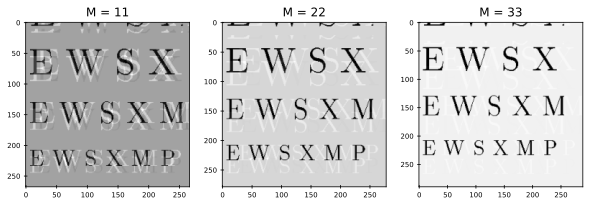

In [11]:
# create impulse responses for filters with M= 11, 22, and 33
M0 = 11
M1 = 22
M2 = 33

h2_n0 = r**np.arange(M0)
h2_n1 = r**np.arange(M1)
h2_n2 = r**np.arange(M2)

# apply each filter to the FILTER-1 result
ech90_decv0 = filter_2d(ech90, h2_n0)
ech90_decv1 = filter_2d(ech90, h2_n1)
ech90_decv2 = filter_2d(ech90, h2_n2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
ax1.imshow(ech90_decv0, cmap="binary")
ax1.set_title("M = 11")

ax2.imshow(ech90_decv1, cmap="binary")
ax2.set_title("M = 22")

ax3.imshow(ech90_decv2, cmap="binary")
ax3.set_title("M = 33")

for ax in (ax1, ax2, ax3):
    ax.grid(False)

# (b) 

Furthermore, when you consider that a gray-scale display has 256 levels, how large is the worst-case error (from the previous part) in terms of number of gray levels? Do this calculation for each of the three filters in part (a). Think about the following question: “Can your eyes perceive a gray scale change of one level, i.e., one part in 256?”


In [12]:
# subtract each filter result from the original image
ech90_decnewshp0 = ech90_decv0[0:-M0, 0:-M0]
ech90_decnewshp1 = ech90_decv1[0:-M1, 0:-M1]
ech90_decnewshp2 = ech90_decv2[0:-M2, 0:-M2]

im_error1 = np.abs(ech90_decnewshp0 - echart)
im_error2 = np.abs(ech90_decnewshp1 - echart)
im_error3 = np.abs(ech90_decnewshp2 - echart)

max_error1 = np.max(im_error1)
max_error2 = np.max(im_error2)
max_error3 = np.max(im_error3)

print("For a scale of 256:")
print(f"Maximum Error found is {256*max_error1}")
print(f"Maximum Error found is {256*max_error2}")
print(f"Maximum Error found is {256*max_error3}")

For a scale of 256:
Maximum Error found is 160.67102519808012
Maximum Error found is 50.42027019180097
Maximum Error found is 15.822415043907938


The maximum error for M=11 is 160.67, M=22 is 50.42 and M=33 is 15.82.
It would be difficult for our eyes to perceive this change. With an error value of ~16, the distortion is nearly imperceivable. If this error value were to approach one part in 256, the distortion would not be visible to the human eye. 